In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import cv2
import tensorflow as tf

from tqdm import tqdm
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape, Activation, Input, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.applications import InceptionV3

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# 1.데이터 로딩

In [ ]:
def get_anchors():
    # Anchor 불러옴
    anchors = []
    with open('../input/wider-face-detection/anchors.txt', 'r') as f:
        for _ in range(5):
            anchor = f.readline()
            anchor = [float(x) for x in anchor.split(',')]
            anchors.append(anchor)
            
        anchors = np.array(anchors)
    return anchors

In [ ]:
def extract_bbx_data(data_dir):
  '''
  train, validation 이미지 파일 경로와 바운딩 박스의 ground truth 값 가져오기.
  Arguments : 
   data_dir : 데이터 저장한 경로 (WIDER_train, WIDER_val, wider_face_split 폴더 저장된 위치)
  Returns :
   data_dict : dictionary. key : 이미지 경로, value : [x1, y1, w, h, ...] (바운딩 박스 ground truth값)
  '''
  train_data_dict = dict()
  val_data_dict = dict()
  for type in ['train', 'val']:
    # bounding box 데이터 들어있는 txt 파일 열기
    with open(os.path.join(data_dir, 'wider_face_split', 'wider_face_%s_bbx_gt.txt' % (type)), 'r') as f:
      lines = f.readlines()
      
      for line in lines:
        line = line.split('\n')[0]
        if line.endswith('.jpg'):
          # 파일 명이 기록된 line일 경우
          image_path = os.path.join(data_dir, 'WIDER_%s' % (type), 'images', line)
          
          if type == 'train':
            train_data_dict[image_path] = []
          else:
            val_data_dict[image_path] = []
        
        label_components = line.split(' ')
        if len(label_components) > 1:
          # label data가 저장된 line일 경우
          
          if int(label_components[7]) != 1:
            # invalid data인 경우 제외. wider_face_split/readme.txt 참조
            x1 = int(label_components[0])
            y1 = int(label_components[1])
            w = int(label_components[2])
            h = int(label_components[3])
            
            if w > 10 and h > 10:
              # bounding box가 너무 작은 경우 제외
              if type == 'train':
                train_data_dict[image_path].append(np.array([x1, y1, x1 + w, y1 + h]))
              else:
                val_data_dict[image_path].append(np.array([x1, y1, x1 + w, y1 + h]))
  
  return (train_data_dict, val_data_dict)

In [ ]:
def load_data(data_dict, pixels_per_grid=32, target_size=[416, 416]):
  '''
  입력 data(image들) 불러오는 함수. anchors 있음.

  # TODO: RAM을 너무 많이 차지한다. validation set 3226개 불러오는데 대략 7GB 사용. 대책 필요.
  #       data_dict을 인자로 받지 말고 데이터 저장 경로를 전달 받아 함수 내에서 extract_bbx_data 호출
  #       메모리 문제 해결되면 train, validation set 같이 반환되게 바꿔보기.
  Arguments: 
   data_dict : 입력 데이터 경로 및 label 저장된 dictionary
   pixels_per_grid : int. 격자 한개당 픽셀 수
   target_size : 출력 데이터의 가로, 세로 사이즈 [n_H, n_W]
  Returns : 
   X_set : numpy array. shape: (m, n_H, n_W, 3)
   Y_set : numpy array. shape: (m, g_H, g_W, num_anchors, 6(x1, y1, w, h, confidence, class_prob))
  '''
  total_size = len(data_dict.keys())
  num_anchors = 5
  anchors = get_anchors()
  n_H = target_size[0]
  n_W = target_size[1]
  grid_h = n_H // pixels_per_grid
  grid_w = n_W // pixels_per_grid
  
  X_set = np.empty((total_size, n_H, n_W, 3), dtype=np.float32)
  Y_set = []
  
  for i, image_path in tqdm(enumerate(data_dict.keys()), total=total_size):
    tmp_img = load_img(image_path)
    ow, oh = tmp_img.size[:2] # 원본 이미지 사이즈 저장
    
    tmp_img = tmp_img.resize((n_W, n_H))
    X_set[i] = image.img_to_array(tmp_img) / 255.0
    Y = np.zeros((grid_h, grid_w, num_anchors, 6))
    
    for x_min, y_min, x_max, y_max in data_dict[image_path]:
      # 좌표를 0~1 사이로 변환하고 고정
      x_min, y_min, x_max, y_max = x_min / ow , y_min / oh, x_max / ow, y_max / oh
      x_min, y_min, x_max, y_max = np.clip([x_min, y_min, x_max, y_max], 0, 1)
      
      anchor_boxes = anchors / np.array([ow, oh])
      best_anchor = get_best_anchor(anchor_boxes, [x_max - x_min, y_max - y_min])
      
      cx = int(np.floor(0.5 * (x_min + x_max) * grid_w))
      cy = int(np.floor(0.5 * (y_min + y_max) * grid_h))
      Y[cx, cy, best_anchor, 0:4] = [x_min, y_min, x_max, y_max]
      Y[cx, cy, best_anchor, 4] = 1.0 # confidence score
      Y[cx, cy, best_anchor, 5] = 1.0 # class prob (face class)
    Y_set.append(Y)
  
  Y_set = np.array(Y_set)
  return X_set, Y_set

In [ ]:
def get_best_anchor(anchors, bbx_wh):
  '''
  바운딩 박스와 가장 비슷한 (IOU 높은) anchor 찾기.
  '''
  bbx_wh = np.array(bbx_wh)
  best_iou = 0
  best_anchor = 0
  for k, anchor in enumerate(anchors):
      intersect_wh = np.maximum(np.minimum(bbx_wh, anchor), 0.0)
      intersect_area = intersect_wh[0] * intersect_wh[1]
      bbx_area = bbx_wh[0] * bbx_wh[1]
      anchor_area = anchor[0] * anchor[1]
      iou = intersect_area / (bbx_area + anchor_area - intersect_area)
      if iou > best_iou:
          best_iou = iou
          best_anchor = k
  return best_anchor

In [ ]:
# 데이터 불러오는 과정 테스트용 코드
data_dir = '../input/wider-face-detection/datasets' # 데이터 저장된 경로

(train_data_dict, val_data_dict) = extract_bbx_data(data_dir)

print("Train data 길이 :", len(train_data_dict))
print("Validation data 길이 :", len(val_data_dict))

Train data 길이 : 12880
Validation data 길이 : 3226


In [ ]:
X_data, Y_data = load_data(val_data_dict) # 데이터 불러오기

100%|██████████| 3226/3226 [00:54<00:00, 57.53it/s]


# 2. 데이터 확인

Input data shape: (3226, 416, 416, 3)


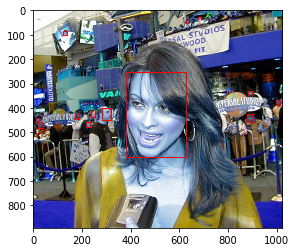

In [ ]:
# 입력 이미지 데이터 확인
index = 500
print("Input data shape:", X_data.shape)
example_img = X_data[index] / 255
plt.imshow(example_img)

# ground-truth 사각형 그리기 테스트

img = list(val_data_dict.keys())[index]
bbx_coords = list(val_data_dict.values())[index]

img = cv2.imread(img)
for x1, y1, x2, y2 in bbx_coords:
  cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
plt.imshow(img)

# 3.데이터 전처리

In [ ]:
# Normalization
#X_data = X_data / 255.0 # 이거 돌리는데 메모리 터짐. 일단 현재 load_data()에서 시행하도록 함

# 추후 Data augmentation

# 4.모델 구성
* Input : 416 x 416
* Classification과 Detection을 위한 네트워크를 분리해서 학습시켜야 한다.
* 논문상에선 Classification Network로 Darknet-19를 사용했고, ImageNet 데이터를 16 epochs만큼 학습.
* 이 Classification Network 부분은 Keras에 VGG16, InceptionV3 등 미리 학습된 모델들이 있는데 이 모델들을 사용해도 되는듯 <br>
-> Darknet-19가 연산량이 다른 모델에 비해 훨씬 적다고는 하는데 학습시킬 시간이 될지 모르겠음. 한번 시도해보고 오래 걸릴거같으면 빠른 손절
* Classification Network를 어느정도 학습시킨 이후, Detection Network 를 추가하여 전체 network를 학습

In [ ]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

input_img = Input(shape=X_data[0].shape)

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_img)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(5 * (4 + 1 + 1), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((13, 13, 5, 4 + 1 + 1))(x)

model = Model(input_img, output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# 5.모델 학습과정 설정(compile)
* Yolo loss function 구현 필요

In [ ]:
# Loss function
def yolo_loss(y_pred, y_true):
    # loss 완성 후 함수 밖으로 뺄 예정
    grid_h, grid_w = 13, 13
    num_classes = 1
    num_anchors = 5
    anchors = get_anchors()
    
    grid_wh = np.reshape([grid_w, grid_h], [1, 1, 1, 1, 2]).astype(np.float32)
    # 예측값 조정(바운딩 박스 위치값 및 가로세로 길이, Confidence score, class probability 0~1사이로 만들기)
    txty = y_pred[..., 0:2]
    twth = y_pred[..., 2:4]
    
    confidence_score = tf.sigmoid(y_pred[..., 4:5])
    class_prob = tf.sigmoid(y_pred[..., 5:])
    
    cxcy = np.transpose([np.tile(np.arange(grid_w), grid_h), np.repeat(np.arange(grid_h), grid_w)])
    cxcy = np.reshape(cxcy, (1, grid_h, grid_w, 1, 2))
    
    bxby = tf.sigmoid(txty) + cxcy
    
    pwph = np.reshape(anchors, (1, 1, 1, num_anchors, 2)) / 32
    bwbh = tf.exp(twth) * pwph

    nxny, nwnh = bxby / grid_wh, bwbh / grid_wh

# 6.모델 학습(fit)

# 7.학습과정 시각화

# 8.모델 테스트